In [1]:
import sys
sys.executable

'/home/rs37890/.conda/envs/diffusion/bin/python'

In [2]:
# setting path
sys.path.append('../')

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
import os
import h5py
import time
import pickle
import argparse
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from IPython.display import display as ipy_display, clear_output

In [5]:
from torch.backends import cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

In [6]:
#https://github.com/lmcinnes/umap/issues/828
# import umap.umap_ as umap

In [7]:
# import utility

In [8]:
import dataset

In [9]:
from my_module import process_gmm

In [10]:
import Deeplabv3 as deplabv3
import networks

# multiprocessing

In [11]:
from multiprocessing import Pool, set_start_method
set_start_method("spawn")

In [12]:
num_cores = os.getenv('SLURM_CPUS_PER_TASK')
num_cores = os.cpu_count()
num_cores = int(num_cores)
num_cores

64

# parameters

In [13]:
source_train_image_sizes = {
0  : (110, 82, 167),
1  : (140, 43, 354),
2  : (308, 65, 295),
3  : (137, 56, 274),
4  : (147, 69, 141),
5  : (171, 75, 127),
6  : (123, 87, 137),
7  : (87, 90, 186),
8  : (100, 78, 149),
9  : (112, 80, 180),
10 : (159, 129, 187),
11 : (131, 62, 316),
12 : (137, 48, 333),
13 : (138, 90, 220),
14 : (146, 126, 136),
15 : (126, 113, 203),
}

In [14]:
target_train_image_sizes = {
0  : (118, 118, 98),
1  : (97, 129, 111),
2  : (119, 107, 118),
3  : (105, 117, 133),
4  : (108, 98, 119),
5  : (119, 113, 128),
6  : (108, 117, 126),
7  : (115, 94, 100),
8  : (133, 108, 127),
9  : (106, 113, 139),
10 : (113, 94, 97),
11 : (108, 88, 116),
12 : (124, 117, 94),
13 : (90, 93, 111),
14 : (95, 95, 113),
15 : (133, 107, 123),
}

# CUDA

In [15]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

# Path

In [16]:
root = "/scratch/rs37890/CARC/Medical_images_source_CT/data/data/"

In [17]:
target_mr_train_dir = root + "h5py/"
target_mr_test_dir = root + "h5py/"

In [18]:
source_ct_train_dir = root + "h5py/"
source_ct_test_dir = root + "h5py/"

# label_ids_abdomen

In [19]:
label_ids = {"ignore": 0,
    "lv_myo": 1,
    "la_blood": 2,
    "lv_blood": 3,
    "aa": 4,
}

# Initialize

In [20]:
def get_dataloader(target_ct_train_dir, target_ct_test_dir, num_classes, batch_size):
    
    dataloader = dataset.get_dataloader( target_ct_train_dir,  target_ct_test_dir, num_classes, batch_size,  domain = 'target'  )
    
    train_dataset = dataloader["train"].dataset
    test_dataset = dataloader["test"].dataset

    return train_dataset, test_dataset

In [21]:
def init_model(num_classes, device, source_dpv3_path, source_classifer_path):

    dpv3 = deplabv3.DeepLabV3(num_classes)
    classifier = networks.classifier(num_classes)
    
    dpv3 = dpv3.to(device)
    classifier = classifier.to(device)
    
    # # parallel
    dpv3 = torch.nn.DataParallel(dpv3)
    classifier = torch.nn.DataParallel(classifier)

    source_dpv3_checkpoint = torch.load(source_dpv3_path)
    source_classifer_checkpoint = torch.load(source_classifer_path)

    dpv3.load_state_dict(source_dpv3_checkpoint)
    classifier.load_state_dict(source_classifer_checkpoint)

    dpv3 = dpv3.module
    classifier = classifier.module

    return dpv3, classifier

# Trainer

In [22]:
# for idx, v in enumerate(target_test_DICE_history):
    
#     if v > 0.6:
#         print(idx)
#         print(target_test_DICE_history[idx])
#         print('-----')

In [23]:
class Trainer:
    def __init__(self, 
                 args, 
                 dpv3, 
                 classifier, 
                 process_gmm,
                 train_dataset, 
                 test_dataset,
                ):

        self.args = args
        self.dpv3 = dpv3
        self.classifier = classifier
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.device = args.device
        self.label_ids = args.label_ids
        self.num_classes = args.num_classes
        self.img_shape = args.img_shape
        self.continue_run = args.continue_run
        self.process_gmm = process_gmm

        self.loss_history = []
        self.target_miou_history = []
        self.target_test_DICE_history = []

        self.optimizer_dpv3 = torch.optim.Adam(self.dpv3.parameters(), 
                                               lr = args.lr, 
                                              )
        
        self.optimizer_classifier = torch.optim.Adam(self.classifier.parameters(), 
                                                     lr = args.lr,
                                                    )
        
        self.lambda2 = 0.1
        self.num_projections = 100
        self.restart_epoch = 0

        self.batch_size = args.batch_size

        self._load_history()

    def _load_history(self):
        if self.continue_run:
            try:
                with open('Adaptation-record-data/loss_history.pkl', "rb") as file:
                    self.loss_history = pickle.load(file)
                with open('Adaptation-record-data/target_miou_history.pkl', "rb") as file:
                    self.target_miou_history = pickle.load(file)
                with open('Adaptation-record-data/target_test_DICE_history.pkl', "rb") as file:
                    self.target_test_DICE_history = pickle.load(file)
                self.restart_epoch = len(self.loss_history)
            except FileNotFoundError:
                pass

    def _save_checkpoint(self, epoch):
        torch.save(self.dpv3.state_dict(), f'./Adaptation-record-data/adapted_dpv3_weights_{epoch}.pth')
        torch.save(self.classifier.state_dict(), f'./Adaptation-record-data/adapted_classifier_weights_{epoch}.pth')
        with open('Adaptation-record-data/loss_history.pkl', "wb") as file:
            pickle.dump(self.loss_history, file)
        with open('Adaptation-record-data/target_miou_history.pkl', "wb") as file:
            pickle.dump(self.target_miou_history, file)
        with open('Adaptation-record-data/target_test_DICE_history.pkl', "wb") as file:
            pickle.dump(self.target_test_DICE_history, file)



    def sliding_window(self, input_volume, window_size=(32, 32, 32), stride=(16, 16, 16)):
    
        z_max = input_volume.shape[0] - window_size[0] + 1
        x_max = input_volume.shape[1] - window_size[1] + 1
        y_max = input_volume.shape[2] - window_size[2] + 1
    
        windows = []
    
        for y in range(0, y_max, stride[2]):
            for x in range(0, x_max, stride[1]):
                for z in range(0, z_max, stride[0]):
                    window = input_volume[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]]
                    windows.append(window)
    
                # z_remaining
                z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
                window = input_volume[z_remaining:, x:x+window_size[1], y:y+window_size[2]]
                windows.append(window)
            
            # x_remaining
            x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
            for z in range(0, z_max, stride[0]):
                window = input_volume[z:z+window_size[0], x_remaining: , y:y+window_size[2]]
                windows.append(window)
                
            # x_remaining z_remaining
            z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            window = input_volume[z_remaining:, x_remaining: , y:y+window_size[2]]
            windows.append(window)
        
        # y_remaining
        y_remaining = input_volume.shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                window = input_volume[z:z+window_size[0], x:x+window_size[1], y_remaining: ]
                windows.append(window)
                
            # y_remaining z_remaining
            z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            window = input_volume[z_remaining:, x:x+window_size[1], y_remaining:]
            windows.append(window)
    
        # y_remaining x_remaining
        x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            window = input_volume[z:z+window_size[0], x_remaining: , y_remaining:]
            windows.append(window)
    
        # y_remaining x_remaining z_remaining
        z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        window = input_volume[z_remaining:, x_remaining: , y_remaining:]
        windows.append(window)
    
        return windows

    def combine_windows(self, window_outputs, input_volume_shape, window_size=(32, 32, 32), stride=(16, 16, 16)):
        num_classes = window_outputs[0].shape[1] # 5
        combined_prob = torch.zeros((num_classes,) + input_volume_shape).to(device)
        count_matrix = torch.zeros(input_volume_shape).to(device)
    
        z_max = input_volume_shape[0] - window_size[0] + 1
        x_max = input_volume_shape[1] - window_size[1] + 1
        y_max = input_volume_shape[2] - window_size[2] + 1
    
        idx = 0
        
        
        for y in range(0, y_max, stride[2]):
            for x in range(0, x_max, stride[1]):
                for z in range(0, z_max, stride[0]):
                    output = window_outputs[idx].squeeze() # output.cpu().numpy().shape: (5, 32, 256, 256)
                    combined_prob[:, z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += output
                    count_matrix[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += 1
                    idx += 1
                    
    
                # z_remaining
                z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
                output = window_outputs[idx].squeeze()
                combined_prob[:, z_remaining:, x:x+window_size[1], y:y+window_size[2]] += output
                count_matrix[z_remaining:, x:x+window_size[1], y:y+window_size[2]] += 1
                idx += 1
            
            # x_remaining
            x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
            for z in range(0, z_max, stride[0]):
                output = window_outputs[idx].squeeze()
                combined_prob[:, z:z+window_size[0], x_remaining: , y:y+window_size[2]] += output
                count_matrix[z:z+window_size[0], x_remaining: , y:y+window_size[2]] += 1
                idx += 1
                
                
            # x_remaining z_remaining
            z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            output = window_outputs[idx].squeeze()
            combined_prob[:, z_remaining:, x_remaining: , y:y+window_size[2]] += output
            count_matrix[z_remaining:, x_remaining: , y:y+window_size[2]] += 1
            idx += 1
            
        
        # y_remaining
        y_remaining = input_volume_shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                output = window_outputs[idx].squeeze()
                combined_prob[:, z:z+window_size[0], x:x+window_size[1], y_remaining: ] += output
                count_matrix[z:z+window_size[0], x:x+window_size[1], y_remaining: ] += 1
                idx += 1
                
                
            # y_remaining z_remaining
            z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            output = window_outputs[idx].squeeze()
            combined_prob[:, z_remaining:, x:x+window_size[1], y_remaining:] += output
            count_matrix[z_remaining:, x:x+window_size[1], y_remaining:] += 1
            idx += 1
            
    
        # y_remaining x_remaining
        x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            output = window_outputs[idx].squeeze()
            combined_prob[:, z:z+window_size[0], x_remaining: , y_remaining:] += output
            count_matrix[z:z+window_size[0], x_remaining: , y_remaining:] += 1
            idx += 1
    
        # y_remaining x_remaining z_remaining
        z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        output = window_outputs[idx].squeeze()
        combined_prob[:, z_remaining:, x_remaining: , y_remaining:] += output
        count_matrix[z_remaining:, x_remaining: , y_remaining:] += 1
        idx += 1
        
        
        # Normalize the class probabilities
        combined_prob /= count_matrix
    
        # Take the argmax of the accumulated probabilities
        combined_output = torch.argmax(combined_prob, dim=0)
    
        return combined_output

    def get_prediction_output(self):

        test_output = []

        for img_idx in range(len(self.test_dataset)): # 0, 1, 2, 3
            
            data_vol, label_vol = self.test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
            data_vol = data_vol.to(device)
            label_vol = label_vol.to(device)
            
            data_vol = torch.squeeze(data_vol, 0) # data_vol:  torch.Size([60, 512, 512])
            windows = self.sliding_window(data_vol) # slice 3D image based on window size and stride
            
            
            
            window_outputs = []
            
            self.dpv3.eval()
            self.classifier.eval() 
            with torch.no_grad():
                for window in windows:
                    window = window.unsqueeze(0)  # Add a channel dimension: torch.Size([1, 32, 256, 256])
                    window = torch.unsqueeze(window, 0)  # Add a batch dimension: torch.Size([1, 1, 32, 256, 256])
                    
                    # inference
                    output = self.dpv3(window)
                    output = self.classifier(output) # torch.Size([1, 5, 32, 256, 256])
                    output = F.softmax(output, dim=1)
                    # collect outputs
                    window_outputs.append(output)  # len(window_outputs) = 27
                    # window_outputs[0].cpu().numpy().shape： (1, 5, 32, 256, 256)
        
            combined_output = self.combine_windows(window_outputs, data_vol.size())
            test_output.append(combined_output)


        numpy_arrays = [tensor.cpu().numpy() for tensor in test_output]
        
        return numpy_arrays

    def compute_dice(self, target_test_predictions):
        
        id_to_ignore = 0
        intersection = dict()
        total = dict()
        for label in label_ids:
            intersection[label] = total[label] = 0
        
        
        for img_idx in range(len(self.test_dataset)): # 0, 1, 2, 3
            
            
            print('img_idx: ', )
            
            _, y_true = self.test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
            
            y_hat = target_test_predictions[img_idx]
            y_true = y_true.cpu().numpy() 
            
            print(y_hat.shape)
            print(y_true.shape)
            
            for label in self.label_ids:
                if label_ids[label] == id_to_ignore:
                    continue
        
                curr_id = self.label_ids[label]
        
                idx_gt = y_true == curr_id
                idx_hat = y_hat == curr_id
        
                intersection[label] += 2 * np.sum(idx_gt & idx_hat)
                total[label] += np.sum(idx_gt) + np.sum(idx_hat)
                
        dice = []
        res = dict()
        for label in label_ids:
            if label_ids[label] == id_to_ignore:
                continue
                
            if total[label] != 0:
                res[label] = intersection[label] / total[label]
            else:
                print('total is zero')
                res[label] = np.float64(0)
        
            dice.append(res[label])

        return res, np.mean(dice)
    
    def compute_miou(self, images, labels, id_to_ignore=0):
        N = len(images)
    
        intersection = dict()
        union = dict()
        for label in self.label_ids:
            intersection[label] = union[label] = 0
    
        self.dpv3.eval()
        self.classifier.eval()
    
        for i in range(N):
            X = images[i].unsqueeze(0).to(self.device)  # (1, 3, 256, 256)
            y_true = labels[i].view(-1).cpu().numpy()
    
            with torch.no_grad():
                myans1 = self.dpv3(X)
                myans2 = self.classifier(myans1)  # output: [1, num_classes, height, width]
    
                # Apply softmax to the output logits
                myans2_softmax = F.softmax(myans2, dim=1)
    
                # Get class predictions by selecting the class with the highest probability
                myans2_pred = torch.argmax(myans2_softmax, dim=1).view(-1).cpu().numpy()
    
            for label in self.label_ids:
                if self.label_ids[label] == id_to_ignore:
                    continue
    
                curr_id = self.label_ids[label]
    
                idx_gt = y_true == curr_id
                idx_hat = myans2_pred == curr_id
    
                intersection[label] += np.sum(idx_gt & idx_hat)
                union[label] += np.sum(idx_gt | idx_hat)
    
        iou_scores = []
        res = dict()
        for label in self.label_ids:
            if self.label_ids[label] == id_to_ignore:
                continue
    
            if union[label] != 0:
                res[label] = intersection[label] / union[label]
            else:
                res[label] = np.float64(0)  # or set to a default value such as 1 if necessary
    
            iou_scores.append(res[label])
    
        return res, np.mean(iou_scores)

    
    def sample_batch(self, dataset, batch_size=20, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        data_dir = dataset.data_dir
        num_samples = len(dataset)
        sample_indices = np.random.choice(num_samples, batch_size, replace=False)
        images = []
        labels = []
        start_positions = []
        target_img_shape = []

        for idx in sample_indices:
            data_vol, label_vol, (sx, sy, sz), data_vol_shape = dataset[idx]
            
            images.append(data_vol)
            labels.append(label_vol)
            start_positions.append([sx, sy, sz])
            target_img_shape.append(data_vol_shape)

        images = torch.stack(images)
        labels = torch.stack(labels)
        start_positions = np.stack(start_positions)

        return images, labels, start_positions, target_img_shape

    def generateTheta(self, L, endim):
        theta_ = np.random.normal(size=(L,endim))
        for l in range(L):
            theta_[l,:]=theta_[l,:]/np.sqrt(np.sum(theta_[l,:]**2))
        return torch.from_numpy(theta_).type(torch.float32).to(self.device)

    def oneDWassersteinV3(self, p, q):
        psort, _ = torch.sort(p, dim=0)
        qsort, _ = torch.sort(q, dim=0)
        
        psort = psort.to(self.device)
        qsort = qsort.to(self.device)
        
        pqmin = torch.min(psort.min(dim=0)[0], qsort.min(dim=0)[0])
        psort = psort - pqmin
        qsort = qsort - pqmin

        n_p = p.size(0)
        n_q = q.size(0)
        
        pcum = torch.cumsum(psort, dim=0) * (max(n_p, n_q) / float(n_p))
        qcum = torch.cumsum(qsort, dim=0) * (max(n_p, n_q) / float(n_q))
        
        indp = torch.floor(torch.linspace(0, n_p - 1, min(n_p, n_q) + 1)).long()
        indq = torch.floor(torch.linspace(0, n_q - 1, min(n_p, n_q) + 1)).long()

        indp = indp.to(self.device)
        indq = indq.to(self.device)
        
        phat = torch.gather(pcum, 0, indp[1:].unsqueeze(1).expand(-1, pcum.size(1))).to(self.device)
        phat = torch.cat((phat[0].unsqueeze(0), phat[1:] - phat[:-1]), dim=0)
        
        qhat = torch.gather(qcum, 0, indq[1:].unsqueeze(1).expand(-1, qcum.size(1))).to(self.device)
        qhat = torch.cat((qhat[0].unsqueeze(0), qhat[1:] - qhat[:-1]), dim=0)
        
        W2 = torch.mean((phat - qhat) ** 2, dim=0)
        return W2

    def sWasserstein_hd(self, P, Q, theta):
        p = torch.matmul(P.view(-1, self.num_classes), theta.t())
        q = torch.matmul(Q.view(-1, self.num_classes), theta.t())
        
        sw = torch.mean(self.oneDWassersteinV3(p, q))  
        return sw

    def Find_Gaussians(self, data, gmms):
        assert len(data.size()) == 4
        data = torch.unsqueeze(data, 0)
        self.dpv3.eval()

        with torch.no_grad():
            input_data = data.to(self.device).float()
            zs = self.dpv3(input_data).cpu()
            zs = zs.permute(0, 2, 3, 4, 1).reshape(-1, self.num_classes).detach().numpy()
            curr_data = zs
        
        max_log_likelihood = -1000000000000000
        best_idx = None

        with Pool(processes=num_cores) as pool:
            results = pool.map(self.process_gmm, [(gmms[idx], idx, curr_data) for idx in range(len(gmms))])

        for log_likelihood, idx in results:
            if log_likelihood > max_log_likelihood:
                max_log_likelihood = log_likelihood
                best_idx = idx
        return best_idx

    def mri_to_ct_index(self, mri_index, ct_length, mri_length):
        scaling_factor = ct_length / mri_length
        return round(mri_index * scaling_factor)

    def get_similar_gaussian(self, start_positions, target_img_shape_list, data):
        df = pd.read_csv('Gaussian_similarity_dataframe_27779.csv')
        means_list = []
        covs_list = []
        label_counts_list = []

        for idx, start_position in enumerate(start_positions):
            i, j, k = start_position
            target_image_size = target_img_shape_list[idx]
            
            gmms = []
            gmms_idx = []
            i_range, j_range, k_range = 9, 9, 9
            
            while len(gmms) == 0:
                final_mask = pd.Series([False] * len(df))
                for source_idx, source_size in source_train_image_sizes.items():
                    ratio_i = self.mri_to_ct_index(i, source_size[0], target_image_size[0])
                    ratio_j = self.mri_to_ct_index(j, source_size[1], target_image_size[1])
                    ratio_k = self.mri_to_ct_index(k, source_size[2], target_image_size[2])
                    mask = (
                        (df['source_i'].between(ratio_i - i_range, ratio_i + i_range)) & 
                        (df['source_j'].between(ratio_j - j_range, ratio_j + j_range)) & 
                        (df['source_k'].between(ratio_k - k_range, ratio_k + k_range)) &
                        (df['source_images_idx'] == source_idx)
                    )
                    final_mask = final_mask | mask
                subset_df = df[final_mask]
                gmms, gmms_idx = self.Get_GMMs(subset_df)
                if len(gmms) == 0:
                    i_range += 9
                    j_range += 9
                    k_range += 9

            best_idx = self.Find_Gaussians(data[idx], gmms)
            df_most_similar_Gaussian = df.loc[gmms_idx[best_idx]]
            means = self.str_to_nparray(df_most_similar_Gaussian['means'], (5, 5))
            covs = self.str_to_nparray(df_most_similar_Gaussian['covs'], (5, 5, 5))
            label_counts = self.str_to_nparray(df_most_similar_Gaussian['label_frequency'], (5,))
            means_list.append(means)
            covs_list.append(covs)
            label_counts_list.append(label_counts)

        return means_list, covs_list, label_counts_list

    def Get_GMMs(self, df):
        eps = 1e-6 
        source_gmms = [] 
        source_gmms_idx = [] 

        for idx, row in df.iterrows():
            means = self.str_to_nparray(row['means'], (5, 5))
            covs = self.str_to_nparray(row['covs'], (5, 5, 5))
            label_counts = self.str_to_nparray(row['label_frequency'], (5,))
            total_count = np.sum(label_counts)
            proportions = label_counts / total_count
            valid_components = []

            for i in range(5):
                if np.count_nonzero(covs[i]) == 0 or np.isnan(covs[i]).any() or np.isinf(covs[i]).any():
                    continue
                eigvals, eigvecs = np.linalg.eig(covs[i])
                eigvals = np.maximum(eigvals, eps)
                covs[i] = eigvecs @ np.diag(eigvals) @ np.linalg.inv(eigvecs)
                covs[i] = covs[i] + eps * np.eye(covs[i].shape[0])
                valid_components.append(i)

            gmm = GaussianMixture(n_components=len(valid_components))
            gmm.covariances_ = covs[valid_components]
            gmm.means_ = means[valid_components]
            gmm.weights_ = proportions[valid_components]
            gmm.precisions_ = np.linalg.inv(gmm.covariances_)
            gmm.precisions_cholesky_ = np.linalg.cholesky(gmm.precisions_)
            source_gmms.append(gmm)
            source_gmms_idx.append(idx)
        return source_gmms, source_gmms_idx

    def str_to_nparray(self, matrix_str, shape):
        matrix_str = matrix_str.replace('[', '').replace(']', '').strip()
        matrix_list = [float(x) for x in matrix_str.split()]
        return np.array(matrix_list).reshape(shape)
        
    def sample_from_gaussians(self, means, covs, n_samples, mask, eps=1e-6):
        n = len(n_samples)
        res_mask = np.zeros_like(mask)
        res_x_mask = np.zeros(mask.shape + (5,))

        for i in range(n):
            if n_samples[i] > 0:
                try:
                    eigs = np.linalg.eigvalsh(covs[i])
                    curr_x = np.random.multivariate_normal(means[i], covs[i], int(n_samples[i]))
                    curr_y = np.repeat(i, n_samples[i])
                    positions = np.where(mask == i)
                    res_mask[positions] = curr_y
                    for j in range(5):
                        res_x_mask[positions + (j,)] = curr_x[:, j]
                except np.linalg.LinAlgError:
                    synthetic_cov = np.eye(means[i].shape[0]) * eps
                    curr_x = np.random.multivariate_normal(means[i], synthetic_cov, int(n_samples[i]))
                    curr_y = np.repeat(i, n_samples[i])
                    positions = np.where(mask == i)
                    res_mask[positions] = curr_y
                    for j in range(5):
                        res_x_mask[positions + (j,)] = curr_x[:, j]
        return res_x_mask, res_mask


    def train_one_epoch(self, epoch, batch_size):
        target_train_data, target_train_labels, start_positions, target_img_shape = self.sample_batch(self.train_dataset, batch_size, seed=epoch)
        target_train_data = target_train_data.to(self.device)
        target_train_labels = target_train_labels.to(self.device)


        print('target_train_data.size(): ', target_train_data.size())
        print('target_train_labels.size(): ', target_train_labels.size())
        
        
        means, covs, _ = self.get_similar_gaussian(start_positions, target_img_shape, target_train_data)
        label_counts = []
        masks = []

        self.dpv3.eval()
        self.classifier.eval()
        with torch.no_grad():
            for batch_idx in range(batch_size):
                X = target_train_data[batch_idx].unsqueeze(0)
                myans1 = self.dpv3(X)
                myans2 = self.classifier(myans1)
                myans2_softmax = F.softmax(myans2, dim=1)
                myans2_pred = torch.argmax(myans2_softmax, dim=1).view(-1).cpu().numpy()
                n_samples = np.zeros(self.num_classes, dtype=int)
                cls, ns = np.unique(myans2_pred, return_counts=True)
                for i in range(len(cls)):
                    n_samples[cls[i]] = ns[i]
                label_counts.append(n_samples)
                masks.append(myans2_pred)

        self.dpv3.train()
        self.classifier.train()

        Yembed, Yembedlabels = [], []
        for batch_idx in range(batch_size):
            sample_data, sample_labels = self.sample_from_gaussians(means[batch_idx], covs[batch_idx], label_counts[batch_idx], masks[batch_idx])
            Yembed.append(sample_data)
            Yembedlabels.append(sample_labels)

        Yembed = torch.tensor(np.stack(Yembed), dtype=torch.float32).to(self.device)
        Yembed = Yembed.reshape(-1, *self.img_shape, self.num_classes).permute(0, 4, 1, 2, 3).contiguous()
        Yembedlabels = torch.tensor(np.stack(Yembedlabels), dtype=torch.long).to(self.device)
        Yembedlabels = Yembedlabels.reshape(-1, *self.img_shape)

        print('Yembed.size(): ', Yembed.size())
        print('Yembedlabels.size(): ', Yembedlabels.size())

        self.optimizer_dpv3.zero_grad()
        self.optimizer_classifier.zero_grad()

        dpv3_outputs = self.dpv3(target_train_data)
        Yembed_outputs = self.classifier(Yembed)

        matching_loss = self.sWasserstein_hd(dpv3_outputs.permute(0, 2, 3, 4, 1).contiguous(), Yembed.permute(0, 2, 3, 4, 1).contiguous(), self.generateTheta(self.num_projections, self.num_classes))
        loss = matching_loss.to(self.device)
        loss.backward()
        self.optimizer_dpv3.step()
        self.optimizer_classifier.step()

        self.loss_history.append((loss.item(), matching_loss.item()))

        target_test_predictions = self.get_prediction_output()
        
        # _, target_miou = self.compute_miou(target_test_predictions)
        _, target_test_miou = self.compute_dice(target_test_predictions)
        _, target_test_dice = self.compute_dice(target_test_predictions)

        self.target_miou_history.append(target_test_miou)
        self.target_test_DICE_history.append(target_test_dice)

        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

    def train(self, epochs=90000, epoch_step=250):
        fig, ax = plt.subplots(2, 1, figsize=(12, 12))
        fig.subplots_adjust(hspace=1)

        for epoch in range(self.restart_epoch, epochs):
            self.train_one_epoch(epoch, self.batch_size)

            if epoch % epoch_step == 0 or epoch < 2000:
                if epoch != 0:
                    ax[0].clear()
                    loss_array = np.asarray(self.loss_history)
                    ax[0].plot(np.log(loss_array[:, 0]), label='log total loss')
                    ax[0].plot(np.log(loss_array[:, 1]), label='log wasserstein loss')
                    ax[0].legend()

                ax[0].set_title("Log Loss")
                ax[0].set_xlabel("Epochs")
                ax[0].set_ylabel("Log Loss")

                if epoch != 0:
                    ax[1].clear()
                    target_array = np.asarray(self.target_test_DICE_history)
                    ax[1].plot(target_array, label='avg')
                    ax[1].legend()

                ax[1].set_title("DICE on all target test data")
                ax[1].set_xlabel("Epochs")
                ax[1].set_ylabel("Mean DICE")


                

                clear_output(wait=True)
                ipy_display(plt.gcf())
                time.sleep(1e-3)

            if epoch % 2 == 0 or epoch == epochs - 1:
                self._save_checkpoint(epoch)
                fig.savefig(f'./training_plot/training_plot_epoch_{epoch}.png')

# Main

In [24]:
def setup_ddp(rank, world_size):

    master_node = subprocess.getoutput("scontrol show hostnames $SLURM_NODELIST | head -n 1")
    master_addr = subprocess.getoutput(f"getent ahosts {master_node} | head -n 1 | awk '{{print $1}}'")
    print('master_addr: ', master_addr)

    # master_addr = '10.2.10.6' # ifconfig -a

    os.environ['NCCL_DEBUG'] = 'INFO'
    os.environ['NCCL_SOCKET_IFNAME'] = 'ib0'  
    
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

In [25]:
def cleanup_ddp():
    dist.destroy_process_group()

# args

In [26]:
parser = argparse.ArgumentParser(description="Training script for DDP-enabled model training.")
parser.add_argument('--epochs', type=int, default=90000, help='Number of epochs to train.')
parser.add_argument('--epoch_step', type=int, default=250, help='Epoch step for displaying logs.')
parser.add_argument('--batch_size', type=int, default=16, help='Batch size for training.')
parser.add_argument('--world_size', type=int, default=torch.cuda.device_count(), help='Number of distributed processes.')
parser.add_argument('--rank', type=int, default=0, help='Rank of the current process.')
parser.add_argument('--continue_run', action='store_true', help='Continue training from the last checkpoint.')

known_args, _ = parser.parse_known_args()
args = known_args
args

Namespace(epochs=90000, epoch_step=250, batch_size=16, world_size=4, rank=0, continue_run=False)

In [27]:
# device = torch.device(f"cuda:{args.rank}" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)

In [28]:
num_classes = 5
batch_size = 4
epoch = 175
continue_run = False
img_shape = (32, 32, 32)

source_dpv3_path = '/scratch/rs37890/CARC/Medical_images_source_CT/Deeplabv3/record-data/dpv3_weights_130000.pth'
source_classifer_path = '/scratch/rs37890/CARC/Medical_images_source_CT/Deeplabv3/record-data/classifier_weights_130000.pth'

In [29]:
args.batch_size = batch_size
args.epoch = 10000
args.continue_run = continue_run
args.num_classes = num_classes
args.lr = 1e-10
args.label_ids = label_ids
args.device = device
args.img_shape = img_shape

# Init

In [30]:
train_dataset, test_dataset = get_dataloader(source_ct_train_dir, source_ct_test_dir, num_classes, batch_size)

In [31]:
dpv3, classifier = init_model(num_classes, device, source_dpv3_path, source_classifer_path)

In [32]:
trainer = Trainer(args,
                  dpv3, 
                  classifier, 
                  process_gmm,
                  train_dataset, 
                  test_dataset,
                 )

In [33]:
len(train_dataset)

16

# Train

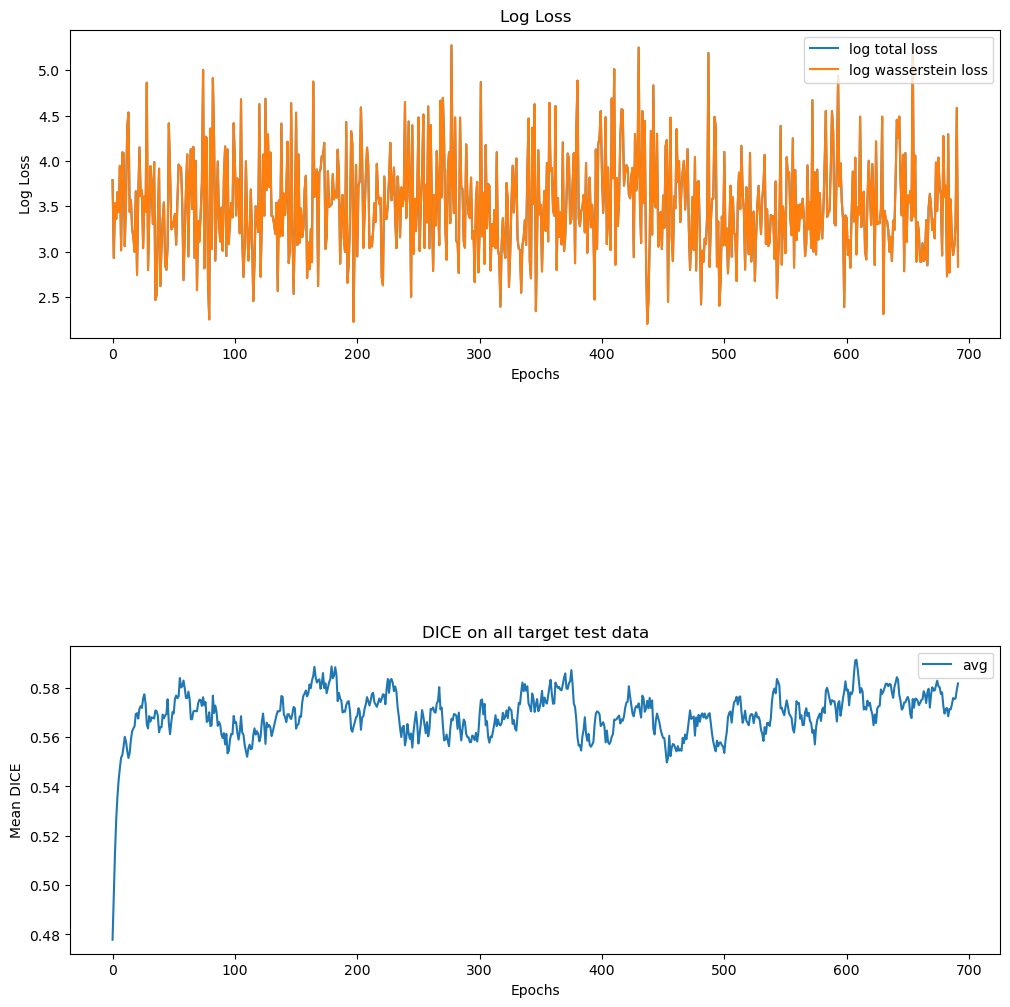

data_vol.shape:  (123, 85, 215)
data_vol.shape:  (159, 129, 187)
data_vol.shape:  (107, 94, 148)
data_vol.shape:  (100, 78, 149)
target_train_data.size():  torch.Size([4, 1, 32, 32, 32])
target_train_labels.size():  torch.Size([4, 32, 32, 32])
Yembed.size():  torch.Size([4, 5, 32, 32, 32])
Yembedlabels.size():  torch.Size([4, 32, 32, 32])
data_vol.shape:  (146, 126, 136)



KeyboardInterrupt

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x154d9024ec10>
Traceback (most recent call last):
  File "/home/rs37890/.conda/envs/diffusion/lib/python3.9/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x154d9265c3a0> (for post_execute):



KeyboardInterrupt



In [34]:
trainer.train()

In [ ]:
filtered_values = [value for value in trainer.target_test_DICE_history if value > 0.59]
filtered_values

# main_worker

In [ ]:
def main_worker(rank, args):

    
    dist.init_process_group( backend = 'nccl',
                             init_method = f'tcp://{master_addr}:{args.port}',
                             world_size = args.world_size, 
                             rank = rank,
                           )

    torch.cuda.set_device(rank)
    # args.num_workers = int(args.num_workers / args.ngpus_per_node)
    device = torch.device(f"cuda:{rank}")


    num_classes = 5
    batch_size = args.batch_size
    suffix = '130000'
    epoch = 175
    
    continue_run = False
    dataset_name = 'abdomen'
    

    train_dataset, test_dataset = get_dataloader(target_ct_train_dir, target_ct_test_dir, num_classes, batch_size)
    dpv3, classifier = init_model(num_classes, device)

    trainer = Trainer(dpv3, 
                      classifier, 
                      train_dataset, 
                      device, 
                      label_ids, 
                      num_classes, 
                      img_shape, 
                      continue_run=False,
                     )
        
    trainer.train()
    
    dist.destroy_process_group()